Analisi dei dati

Colonna temporale trovata: _time
Campo: co2 | Varianza originale: 2493.9748


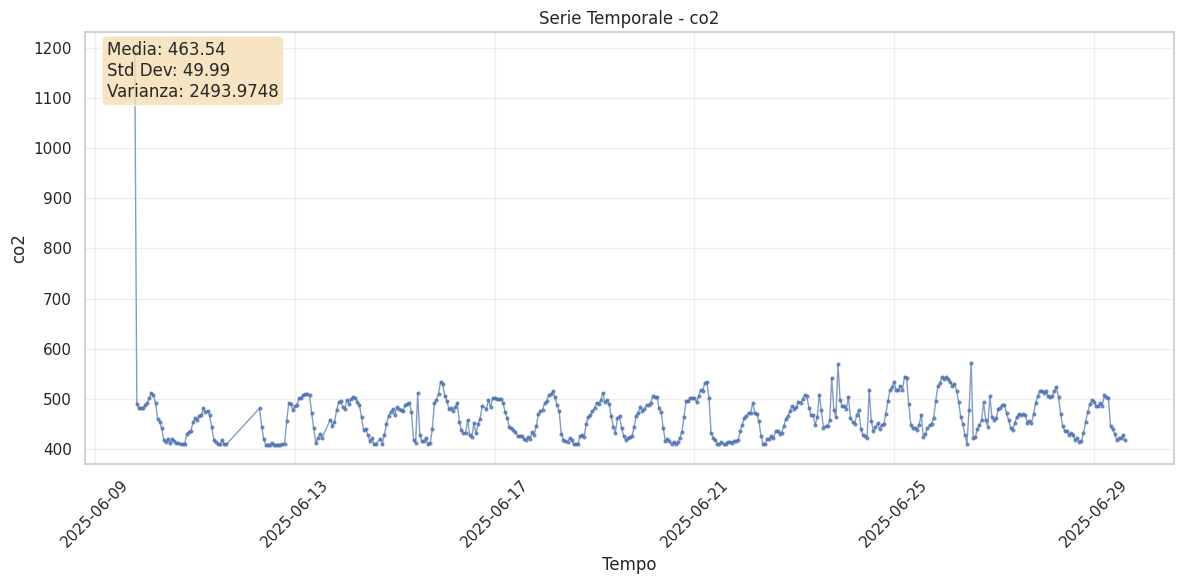

Campo: eco2 | Varianza originale: 36391.1029


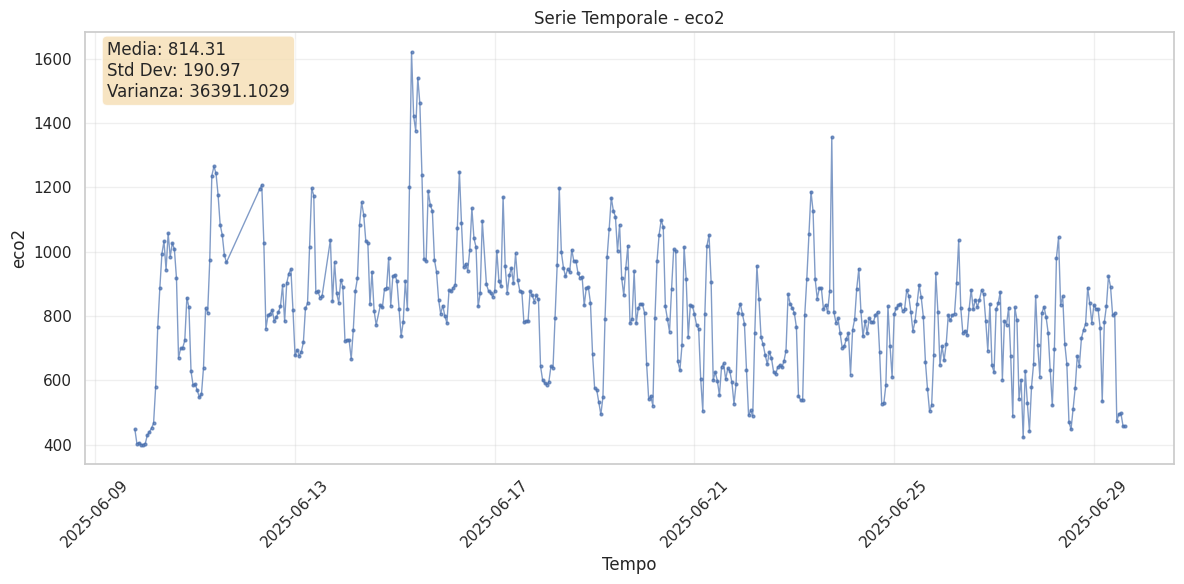

Campo: humidity | Varianza originale: 448.1058
Campo: humidity | Varianza dopo pulizia: 275.9840


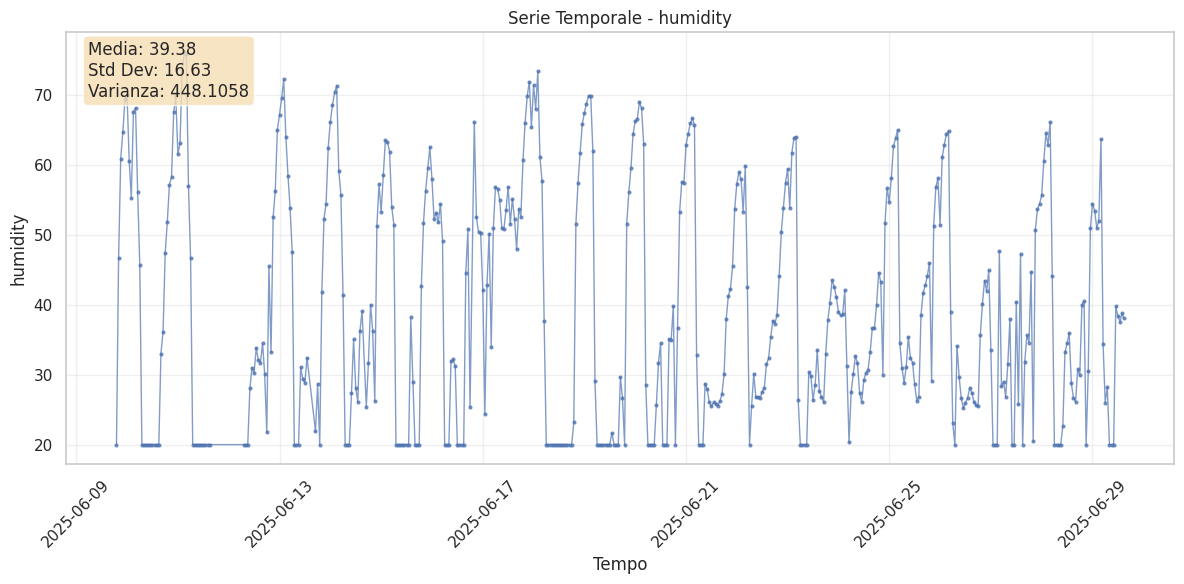

Campo: pm10p0 | Varianza originale: 63.5923


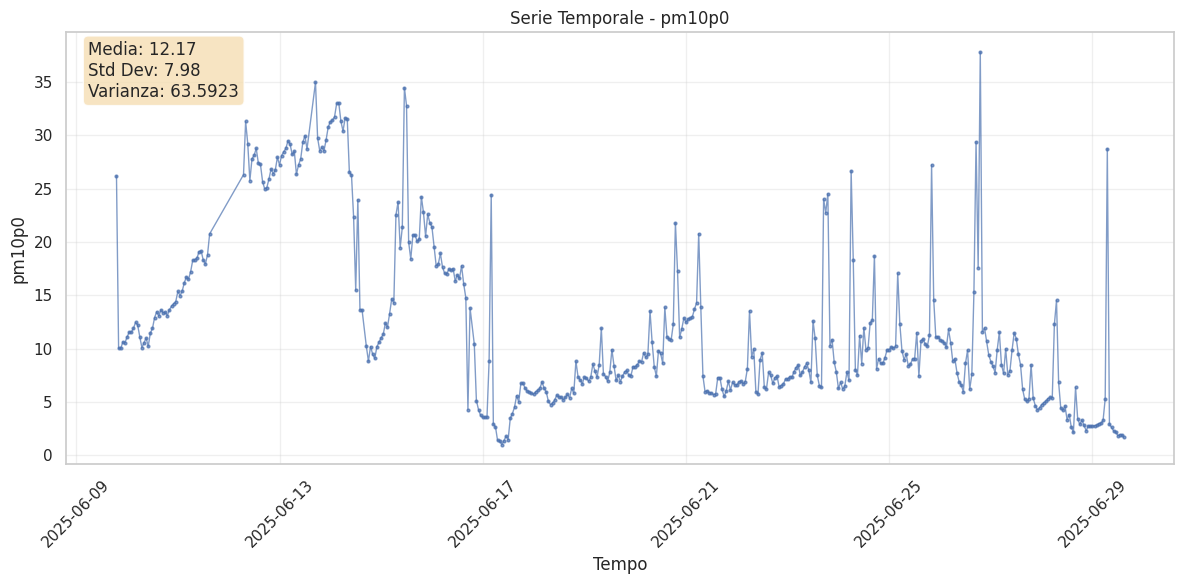

Campo: pm1p0 | Varianza originale: 48.8831


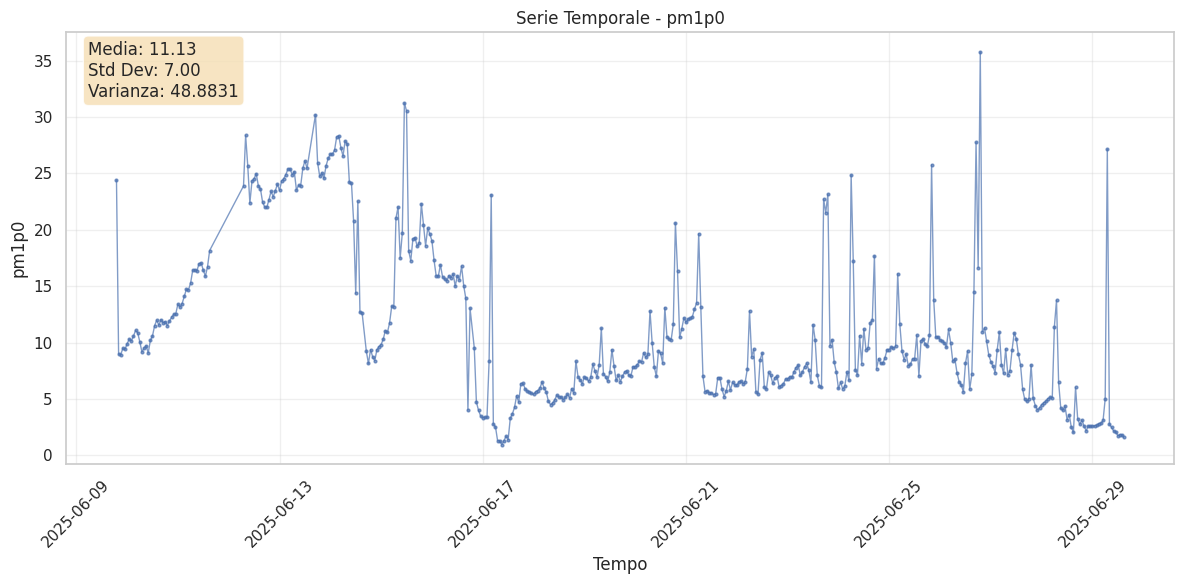

Campo: pm2p5 | Varianza originale: 58.4994


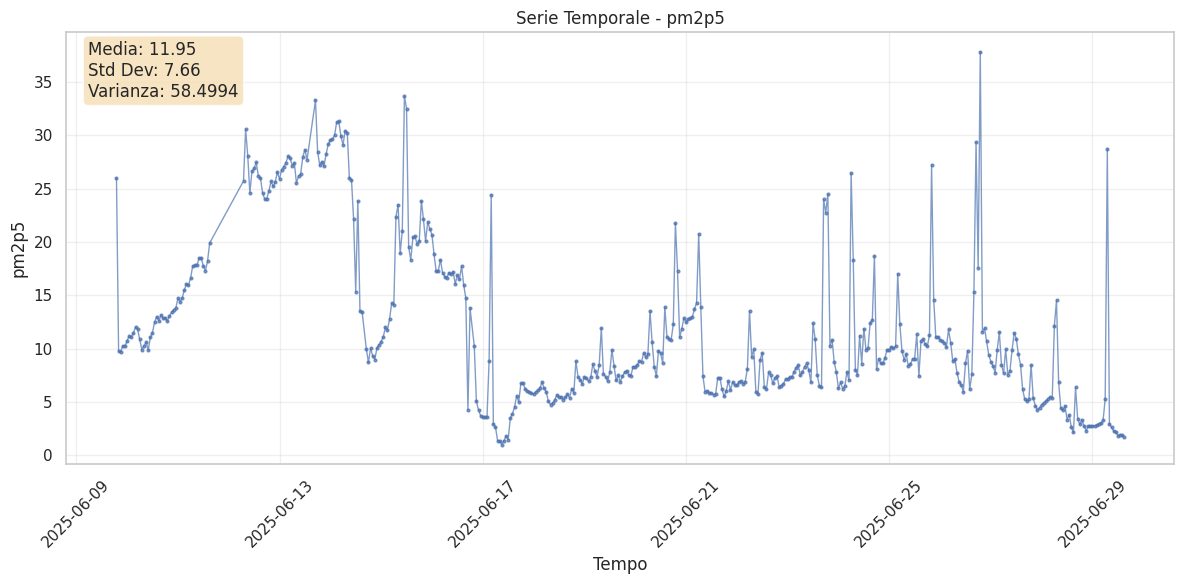

Campo: pm4p0 | Varianza originale: 61.8585


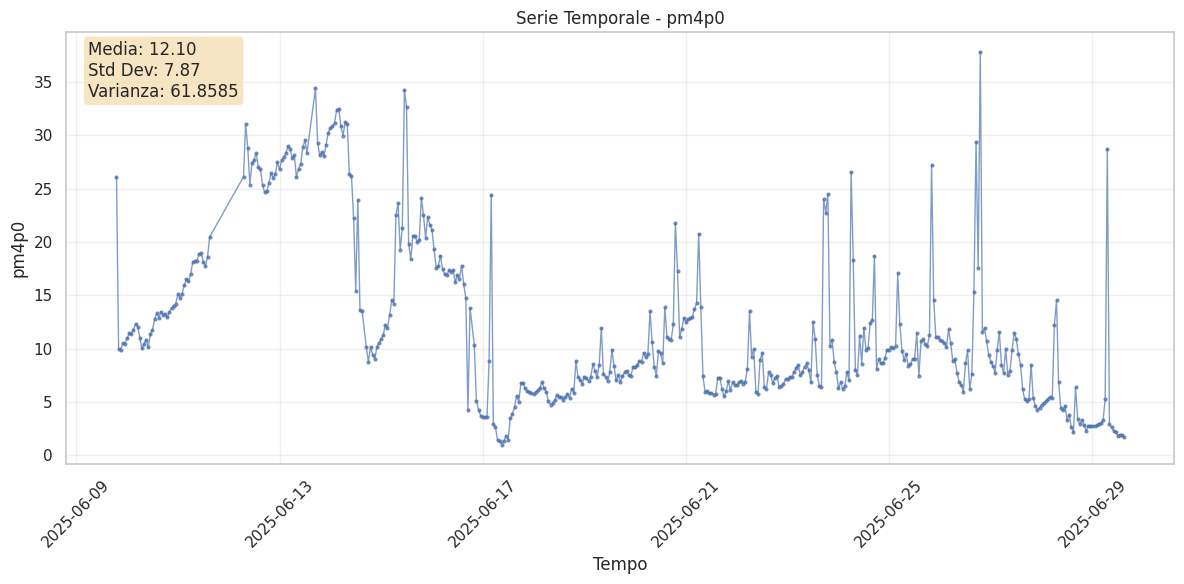

Campo: pressure | Varianza originale: 4.7460


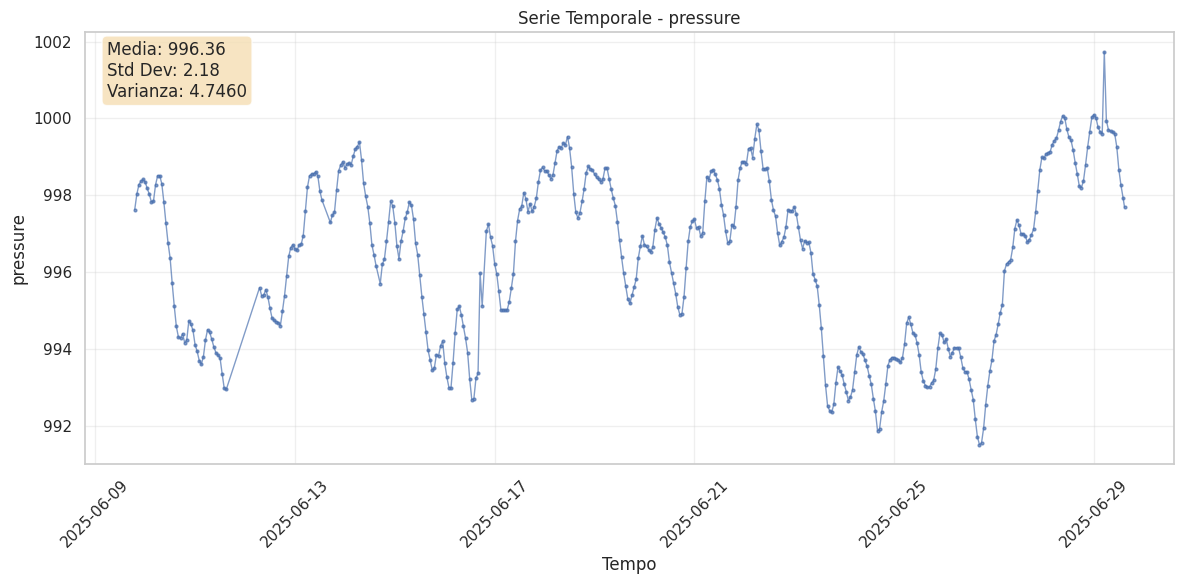

Campo: temperature_avg | Varianza originale: 36.5459


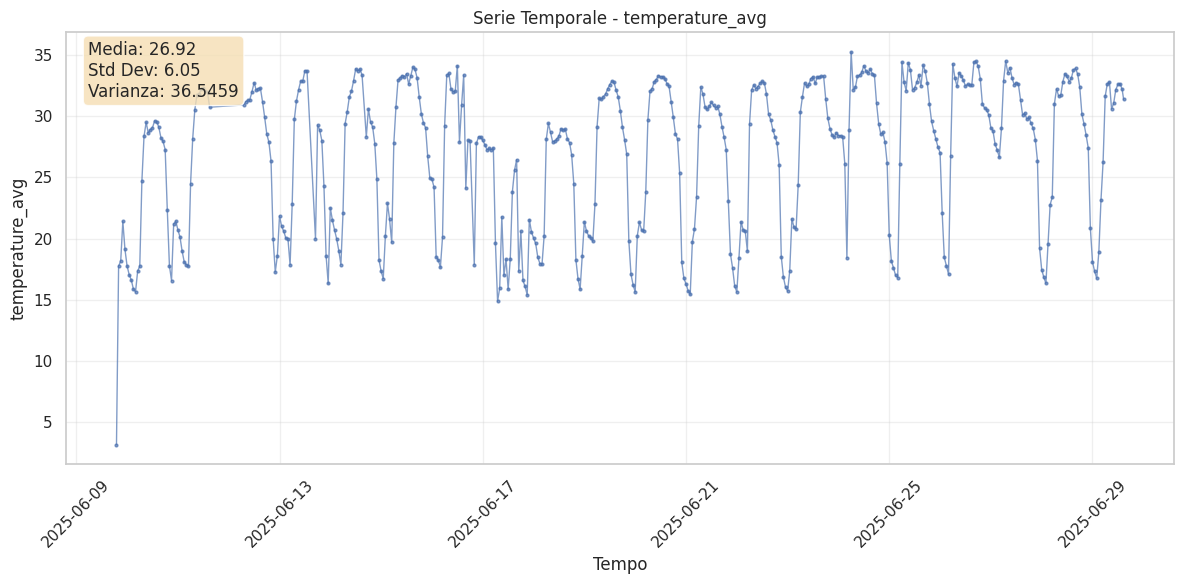

Campo: tvoc | Varianza originale: 303203.7071


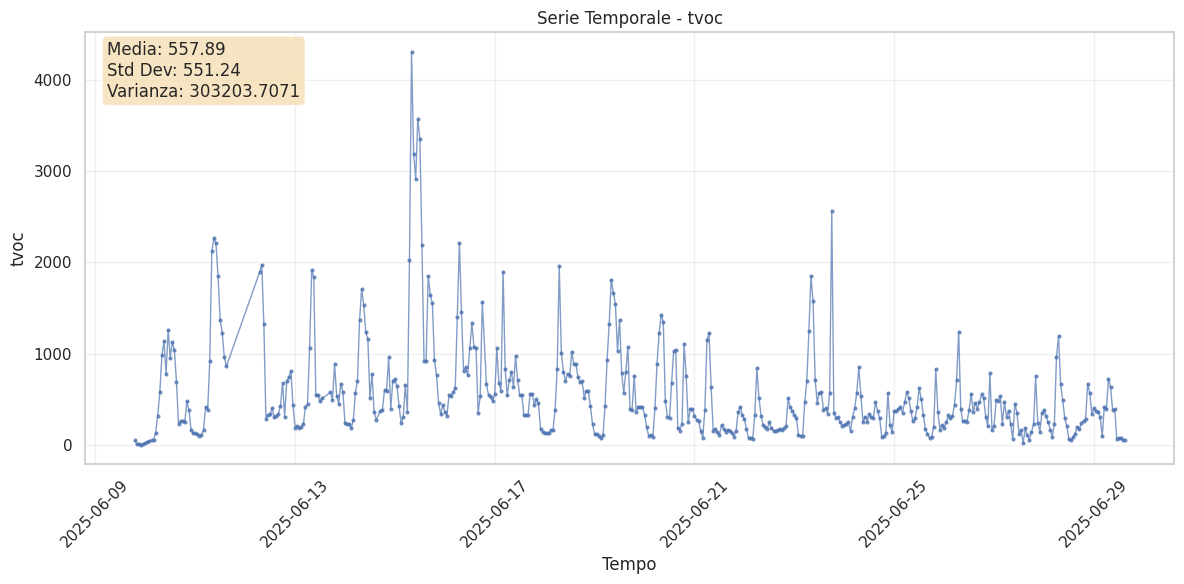

Campo: typical_particle_size | Varianza originale: 0.0020


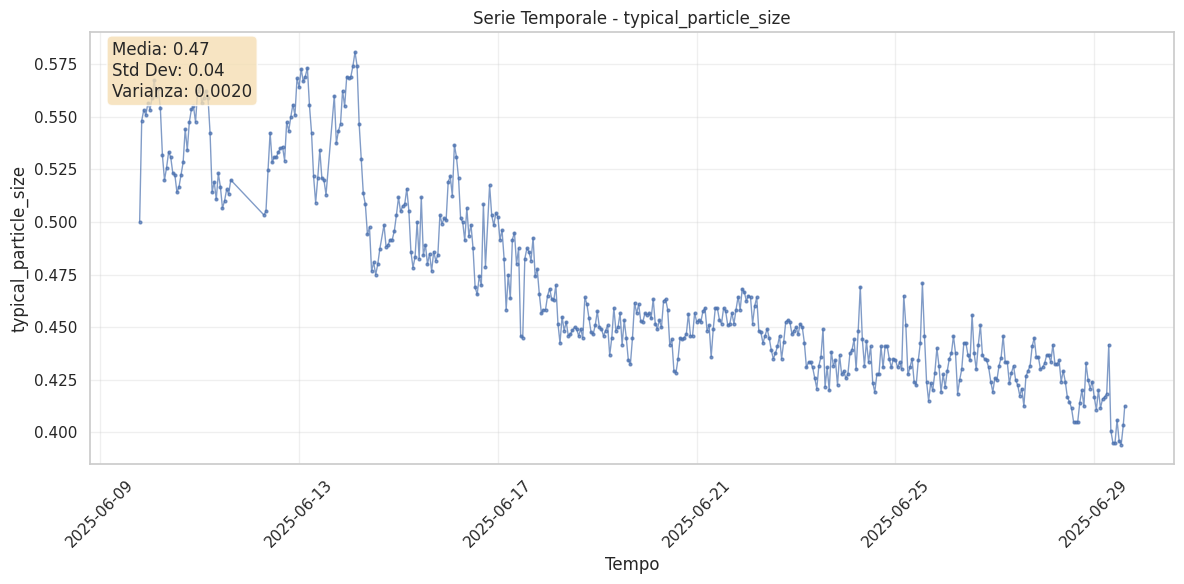


Dataset pulito salvato come 'dataset_pulito.csv' con 5027 righe.
Campi processati: co2, eco2, humidity, pm10p0, pm1p0, pm2p5, pm4p0, pressure, temperature_avg, tvoc, typical_particle_size


In [1]:
# ==============================================================================
# SCRIPT PER ANALISI E VISUALIZZAZIONE DEI DATI DI QUALITÀ DELL'ARIA
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

sns.set_theme(style="whitegrid")

# Caricamento file
nome_file_csv = 'influxdb_data.csv'
if not os.path.exists(nome_file_csv):
    print(f"ERRORE: File '{nome_file_csv}' non trovato.")
    df = None
else:
    df = pd.read_csv(nome_file_csv, comment='#')

# Verifica che il file sia caricato correttamente
if df is not None and {'_field', '_value'}.issubset(df.columns):
    output_data = []

    # Crea cartella per i grafici
    os.makedirs("grafici", exist_ok=True)

    # Converti la colonna temporale (assumendo che si chiami '_time' o 'time')
    time_columns = [col for col in df.columns if 'time' in col.lower()]
    if time_columns:
        time_col = time_columns[0]
        # Use format='ISO8601' and errors='coerce' to handle timestamp variations
        df[time_col] = pd.to_datetime(df[time_col], format='ISO8601', errors='coerce')
        print(f"Colonna temporale trovata: {time_col}")
    else:
        print("ATTENZIONE: Nessuna colonna temporale trovata. I grafici potrebbero non essere ordinati correttamente.")
        time_col = None

    # Itera su ogni tipo di campo (es: temperature, humidity, etc.)
    for field in df['_field'].unique():
        dati_field = df[df['_field'] == field].copy()

        # Ordina per tempo se disponibile
        if time_col:
            dati_field = dati_field.sort_values(time_col)

        # CALCOLA LA VARIANZA PRIMA di applicare modifiche ai dati
        varianza_originale = np.var(dati_field['_value'])
        print(f"Campo: {field} | Varianza originale: {varianza_originale:.4f}")

        # Se humidity, applica soglia minima 20% DOPO aver calcolato la varianza
        if field.lower() == 'humidity':
            dati_field['_value_pulito'] = dati_field['_value'].apply(lambda x: max(x, 20))
            varianza_pulita = np.var(dati_field['_value_pulito'])
            print(f"Campo: {field} | Varianza dopo pulizia: {varianza_pulita:.4f}")
            valore_da_plottare = '_value_pulito'
        else:
            dati_field['_value_pulito'] = dati_field['_value']
            valore_da_plottare = '_value'

        # PLOT COME SERIE TEMPORALE
        plt.figure(figsize=(12, 6))

        if time_col:
            # Serie temporale vera e propria
            plt.plot(dati_field[time_col], dati_field[valore_da_plottare],
                    marker='o', markersize=2, linewidth=1, alpha=0.7)
            plt.xlabel('Tempo')
            plt.xticks(rotation=45)
        else:
            # Se non c'è colonna temporale, usa l'indice
            plt.plot(dati_field.index, dati_field[valore_da_plottare],
                    marker='o', markersize=2, linewidth=1, alpha=0.7)
            plt.xlabel('Indice campione')

        plt.title(f'Serie Temporale - {field}')
        plt.ylabel(field)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Aggiune le statistiche come testo nel grafico
        media = dati_field[valore_da_plottare].mean()
        std_dev = dati_field[valore_da_plottare].std()
        plt.text(0.02, 0.98, f'Media: {media:.2f}\nStd Dev: {std_dev:.2f}\nVarianza: {varianza_originale:.4f}',
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        # Salva il grafico
        plt.savefig(f"grafici/{field}_timeseries.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # Istogramma per vedere la distribuzione
        plt.figure(figsize=(8, 5))
        sns.histplot(dati_field[valore_da_plottare], bins=30, kde=True)
        plt.title(f'Distribuzione - {field}')
        plt.xlabel(field)
        plt.ylabel("Frequenza")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"grafici/{field}_distribution.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Aggiungi al dataset pulito (usa sempre _value_pulito)
        dati_field['_field'] = field
        dati_field['_value'] = dati_field['_value_pulito']  # Sostituisci con valore pulito
        output_data.append(dati_field[['_field', '_value'] + ([time_col] if time_col else [])])

    # Unisci tutti i dati filtrati e salvati
    df_pulito = pd.concat(output_data, ignore_index=True)
    df_pulito.to_csv("dataset_pulito.csv", index=False)
    print(f"\nDataset pulito salvato come 'dataset_pulito.csv' con {len(df_pulito)} righe.")
    print(f"Campi processati: {', '.join(df['_field'].unique())}")

else:
    print("ERRORE: Il dataset non contiene le colonne '_field' e '_value'.")
    if df is not None:
        print(f"Colonne disponibili: {list(df.columns)}")

Addestramento del modello

Forma dataset per modello: (457, 8)
Periodo dati: 2025-06-09 19:00:00+00:00 - 2025-06-29 14:42:44.690719066+00:00


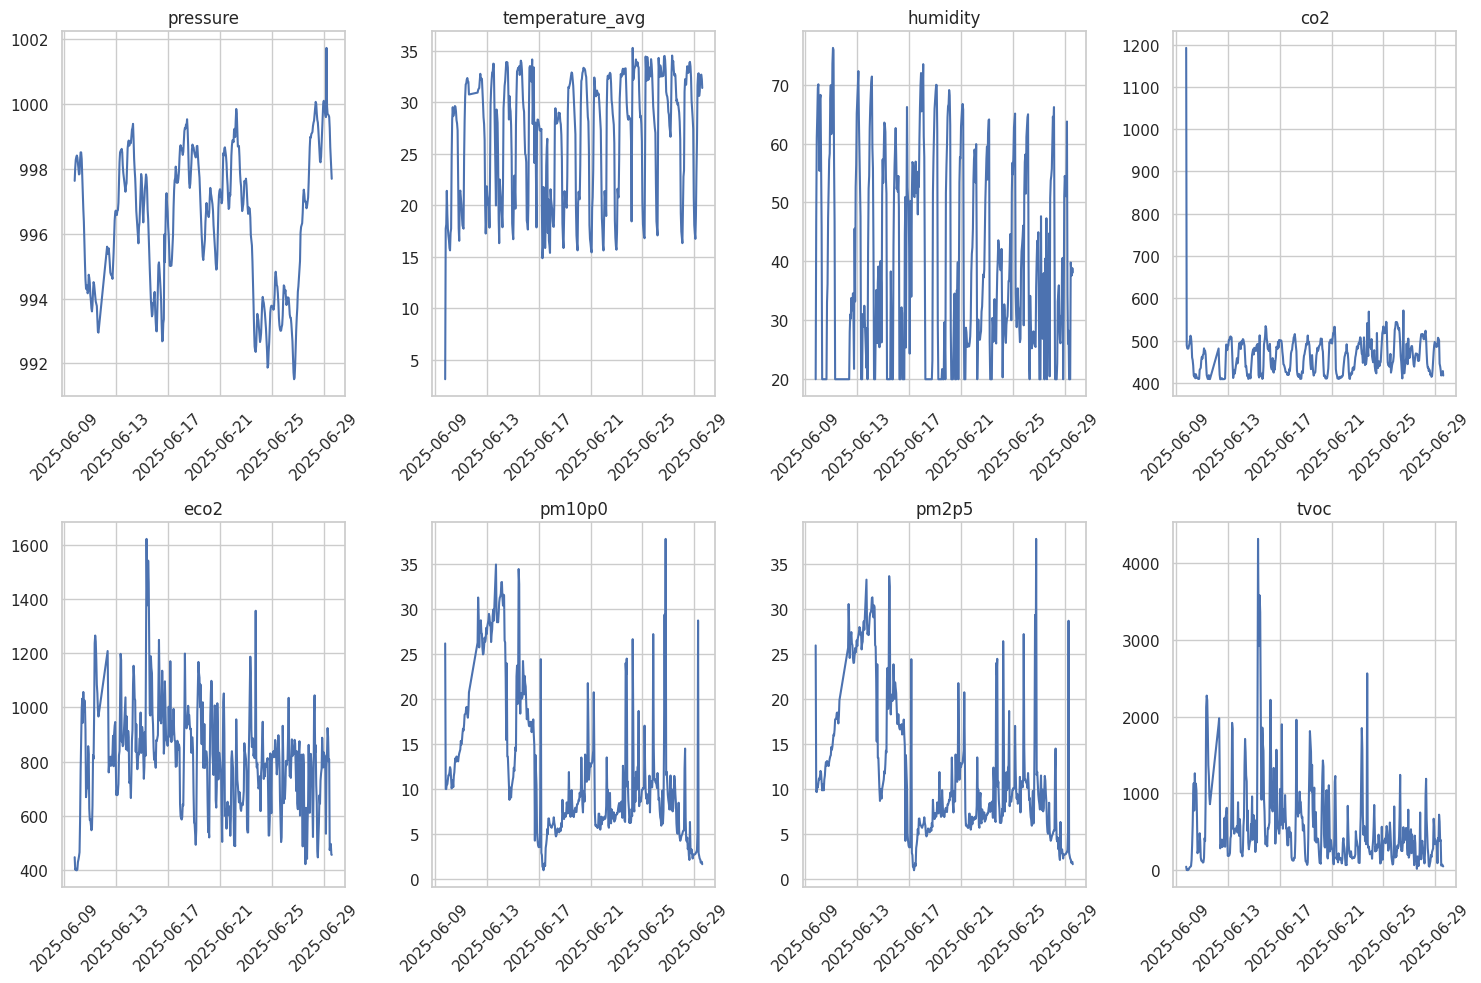

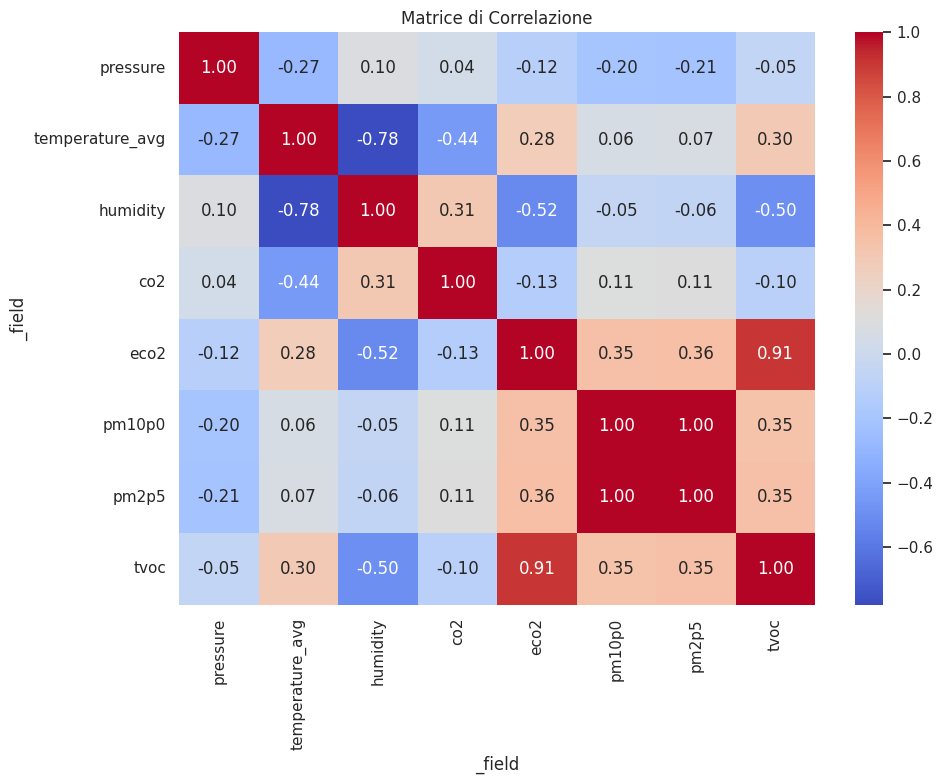

Forma X: (410, 36, 3)
Forma y: (410, 12, 5)
Train: (246, 36, 3), (246, 12, 5)
Valid: (82, 36, 3), (82, 12, 5)
Test: (82, 36, 3), (82, 12, 5)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 32, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 30, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 13, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 208)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │        10,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 60)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 12, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,453 (72.08 KB)

 Trainable params: 18,453 (72.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - loss: 0.1290 - mean_absolute_error: 0.2851 - val_loss: 0.0678 - val_mean_absolute_error: 0.1970
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0958 - mean_absolute_error: 0.2393 - val_loss: 0.0532 - val_mean_absolute_error: 0.1723
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0795 - mean_absolute_error: 0.2185 - val_loss: 0.0437 - val_mean_absolute_error: 0.1582
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0661 - mean_absolute_error: 0.2028 - val_loss: 0.0366 - val_mean_absolute_error: 0.1444
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0558 - mean_absolute_error: 0.1855 - val_loss: 0.0352 - val_mean_absolute_error: 0.1518
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0494 - mean_absolute_error: 0.1794 - val_loss: 0.0322 - val_mean_absolute_error: 0.1469
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0461 - mean_absolute_error: 0.1739 - val_loss: 0.02

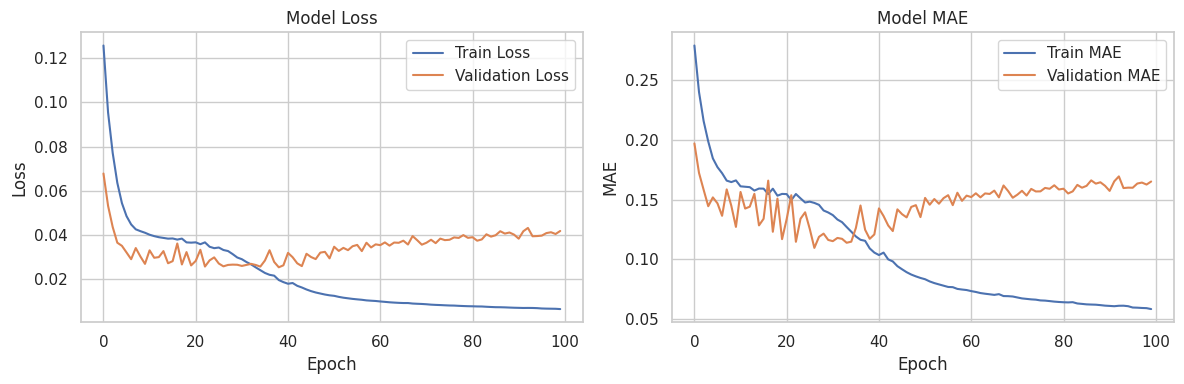


Test Loss: 0.0463
Test MAE: 0.1738


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

Valutazione per variabile:
co2 -> MSE: 1200.1734, R2: 0.1032
eco2 -> MSE: 84207.4194, R2: -3.7346
pm10p0 -> MSE: 56.7799, R2: -0.7107
pm2p5 -> MSE: 56.1583, R2: -0.6933
tvoc -> MSE: 602086.6964, R2: -9.8810


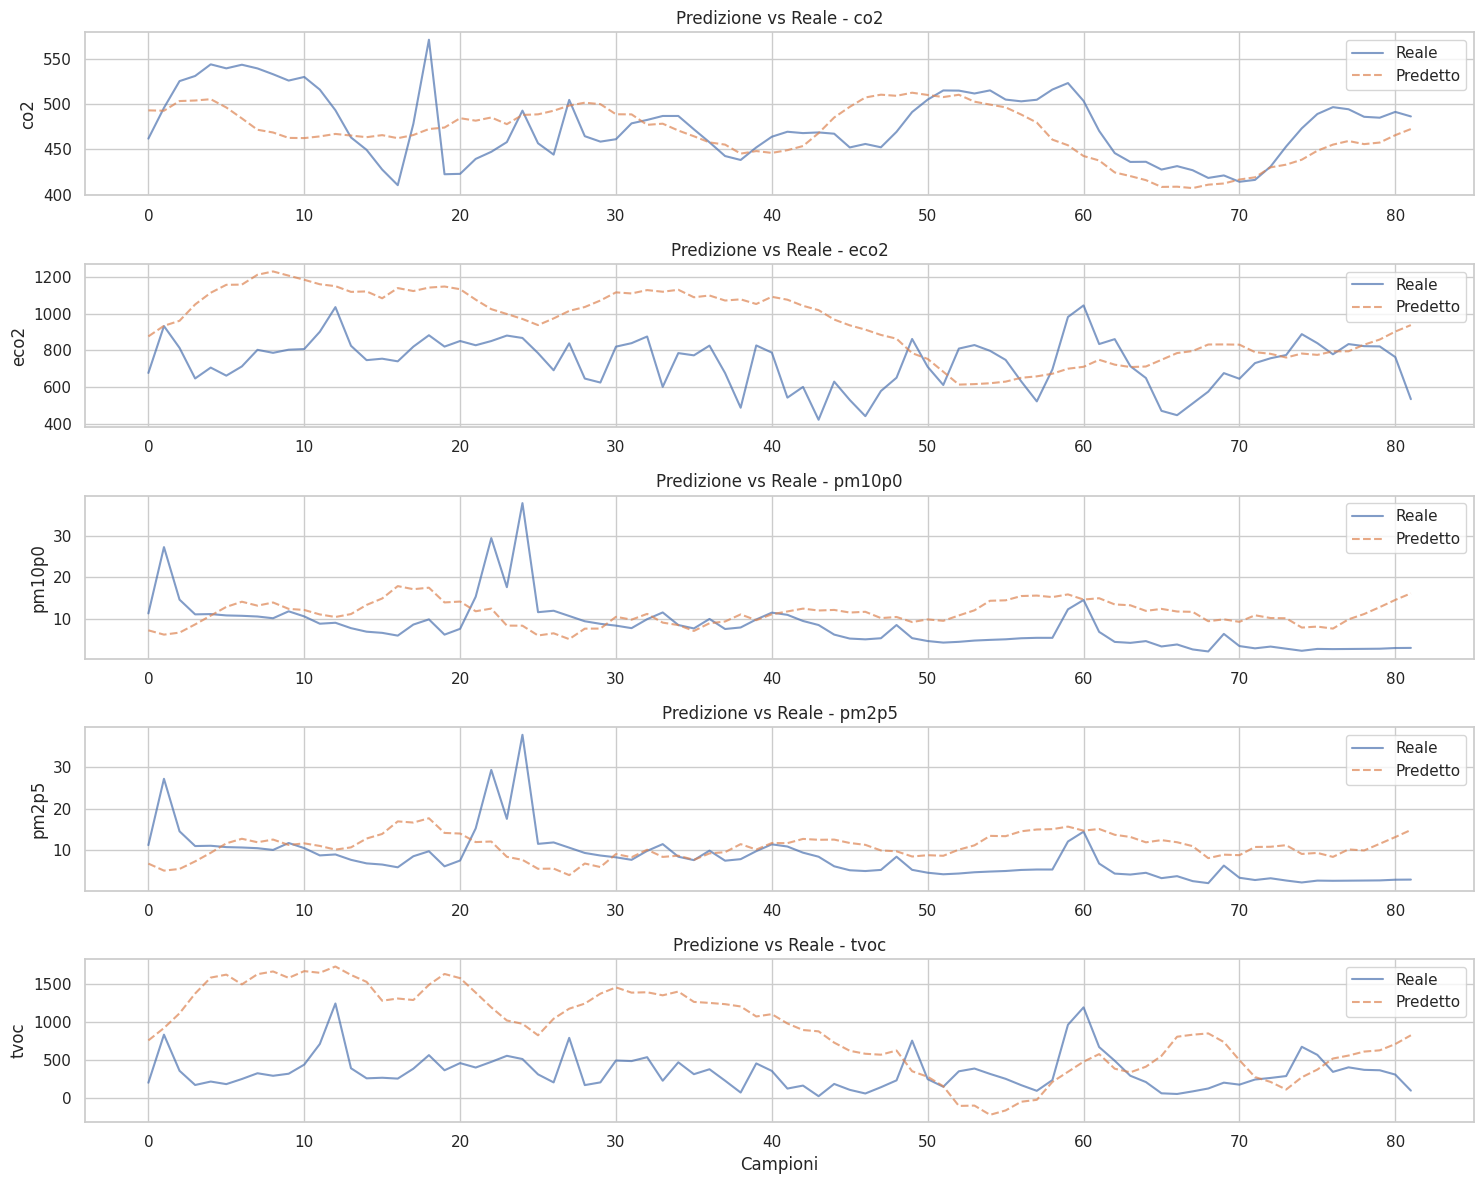

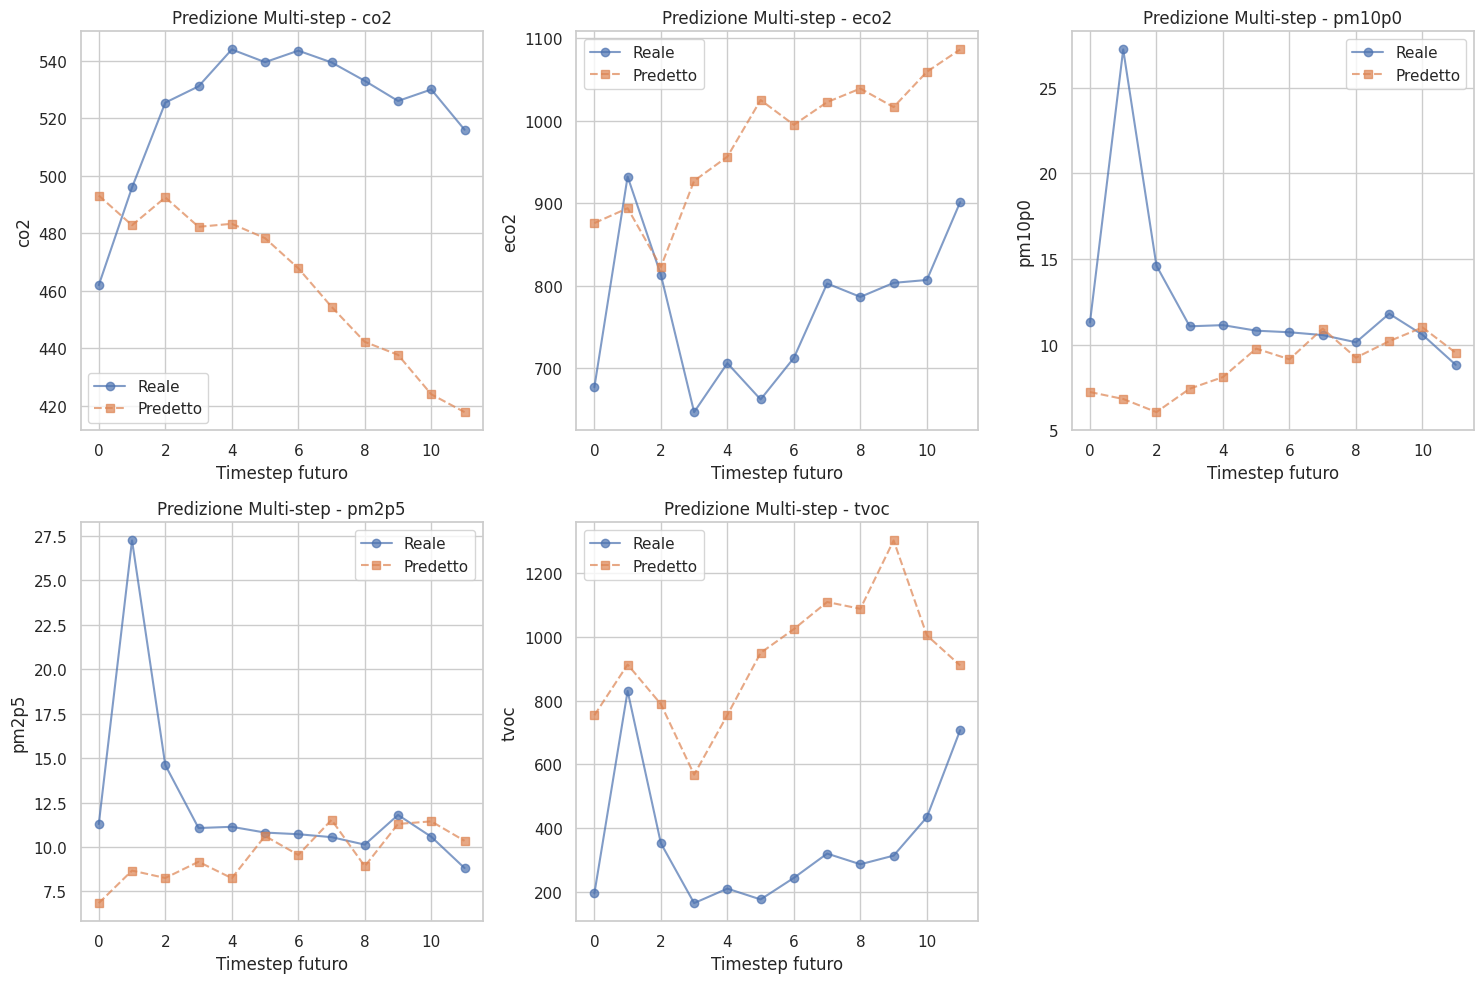

Saved artifact at '/tmp/tmpvmm4ay47'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 36, 3), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 12, 5), dtype=tf.float32, name=None)
Captures:
  138751237930832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751237930640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751237914704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751237925456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751237928336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751237915280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751237918160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751235000272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751235002000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751234998736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138751234998544: Tensor

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import numpy as np
import pandas as pd
import os
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Caricamento dati ambientali
nome_file_csv = 'dataset_pulito.csv'
if not os.path.exists(nome_file_csv):
    print(f"ERRORE: File '{nome_file_csv}' non trovato.")
    df = None
else:
    df = pd.read_csv(nome_file_csv, comment='#')

if df is not None:
    # Trova colonna temporale
    time_col = [col for col in df.columns if 'time' in col.lower()]
    if time_col:
        time_col = time_col[0]
    else:
        raise ValueError("Colonna temporale non trovata.")

    # Pivot per trasformare da long a wide
    df_pivot = df.pivot(index=time_col, columns="_field", values="_value")
    df_pivot = df_pivot.dropna()

    # Conversione index a datetime
    df_pivot.index = pd.to_datetime(df_pivot.index, format='ISO8601')

    # Variabili del sistema
    features = ["pressure", "temperature_avg", "humidity"]
    targets = ["co2", "eco2", "pm10p0", "pm2p5", "tvoc"]

    # Select only the relevant columns for the model
    df_model = df_pivot[features + targets]

    print(f"Forma dataset per modello: {df_model.shape}")
    print(f"Periodo dati: {df_model.index.min()} - {df_model.index.max()}")


    # Visualizzazione serie temporali
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(features + targets):
        plt.subplot(2, 4, i+1)
        plt.plot(df_model.index, df_model[col])
        plt.title(f'{col}')
        plt.xticks(rotation=45)
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Matrice di correlazione
    plt.figure(figsize=(10, 8))
    corr_matrix = df_model[features + targets].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matrice di Correlazione")
    plt.tight_layout()
    plt.savefig("correlazione.png", dpi=300)
    plt.show()

# Funzione per creare finestre temporali multi-step
def df_to_time_steps_multivariate(df, input_window, forecast_steps, feature_cols, target_cols):

    X_data = []
    y_data = []

    # Find the indices of target columns within the input DataFrame
    target_indices = [df.columns.get_loc(col) for col in target_cols]


    for i in range(len(df) - input_window - forecast_steps + 1):
        # Finestra di input: solo variabili features
        X_window = df[feature_cols].iloc[i:i+input_window].values
        # Finestra di output: solo variabili target
        # Select target columns using their indices to ensure correct order
        y_window = df.iloc[i+input_window:i+input_window+forecast_steps, target_indices].values

        X_data.append(X_window)
        y_data.append(y_window)

    return np.array(X_data), np.array(y_data)

# Parametri del modello
# 3 ore di finestra input = 36 timesteps (ogni 5 minuti)
input_window = 36
# Predizione per la prossima ora = 12 timesteps
forecast_steps = 12

# Creazione dataset temporale using the filtered DataFrame and specifying feature_cols
X, y = df_to_time_steps_multivariate(df_model, input_window, forecast_steps, features, targets)


print(f"Forma X: {X.shape}")  # (samples, timesteps, features)
print(f"Forma y: {y.shape}")  # (samples, forecast_steps, targets)

# Normalizzazione dati
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, y.shape[-1])).reshape(y.shape)

# Split train, validation, test (60%, 20%, 20%)
train_samples = int(0.6 * len(X_scaled))
valid_samples = int(0.2 * len(X_scaled))
test_samples = len(X_scaled) - (train_samples + valid_samples)

X_train = X_scaled[:train_samples]
X_valid = X_scaled[train_samples:train_samples+valid_samples]
X_test = X_scaled[-test_samples:]

y_train = y_scaled[:train_samples]
y_valid = y_scaled[train_samples:train_samples+valid_samples]
y_test = y_scaled[-test_samples:]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Valid: {X_valid.shape}, {y_valid.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

def make_cnn_model_multivariate(input_window, n_features, forecast_steps, n_targets, conv_filters):

    model = keras.Sequential([
        tf.keras.layers.Input(shape=(input_window, n_features), name="input"),
        tf.keras.layers.Conv1D(conv_filters, kernel_size=5, activation='relu'),
        tf.keras.layers.Conv1D(conv_filters, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(conv_filters//2, kernel_size=3, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(forecast_steps * n_targets, activation='linear'),
        tf.keras.layers.Reshape((forecast_steps, n_targets))
    ])

    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mean_absolute_error']
    )
    return model

# Creazione e training del modello
n_features = len(features)
n_targets = len(targets)


model = make_cnn_model_multivariate(
    input_window=input_window,
    n_features=n_features,
    forecast_steps=forecast_steps,
    n_targets=n_targets,
    conv_filters=32
)

model.summary()

# Training
epochs = 100
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Valutazione del modello
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Predizioni
y_pred_scaled = model.predict(X_test)

# Denormalizzazione
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, n_targets)).reshape(y_pred_scaled.shape)
y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, n_targets)).reshape(y_test.shape)

# Valutazione per ogni variabile target
print("\nValutazione per variabile:")
for i, target in enumerate(targets):
    # Prendi solo il primo step di predizione per confronto
    mse = mean_squared_error(y_test_denorm[:, 0, i], y_pred[:, 0, i])
    r2 = r2_score(y_test_denorm[:, 0, i], y_pred[:, 0, i])
    print(f"{target} -> MSE: {mse:.4f}, R2: {r2:.4f}")

# Visualizzazione predizioni vs reali
fig, axes = plt.subplots(len(targets), 1, figsize=(15, 12))
if len(targets) == 1:
    axes = [axes]

for i, target in enumerate(targets):
    # Mostra prime 100 predizioni per chiarezza
    n_show = min(100, len(y_test_denorm))

    axes[i].plot(y_test_denorm[:n_show, 0, i], label='Reale', alpha=0.7)
    axes[i].plot(y_pred[:n_show, 0, i], label='Predetto', linestyle='--', alpha=0.7)
    axes[i].set_title(f'Predizione vs Reale - {target}')
    axes[i].set_ylabel(target)
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel('Campioni')
plt.tight_layout()
plt.savefig("predizioni_multiple.png", dpi=300)
plt.show()

# Esempio di predizione multi-step per un singolo campione
sample_idx = 0
sample_pred = y_pred[sample_idx]  # (forecast_steps, n_targets)
sample_real = y_test_denorm[sample_idx]

plt.figure(figsize=(15, 10))
for i, target in enumerate(targets):
    plt.subplot(2, 3, i+1)
    plt.plot(range(forecast_steps), sample_real[:, i], 'o-', label='Reale', alpha=0.7)
    plt.plot(range(forecast_steps), sample_pred[:, i], 's--', label='Predetto', alpha=0.7)
    plt.title(f'Predizione Multi-step - {target}')
    plt.xlabel('Timestep futuro')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("predizione_multistep_esempio.png", dpi=300)
plt.show()

# Conversione in TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Salvataggio modello TFLite
with open('environmental_model.tflite', 'wb') as f:
    f.write(tflite_model)